In [1]:
import numpy as np
import pandas as pd
from spec_id import Gen_spec
import matplotlib.pyplot as plt
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
pandas2ri.activate()

In [22]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631 and ids != 41148')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [4]:
rzoo = importr('zoo')

In [44]:
waves = np.array([])
flux = np.array([])
error = np.array([])
mflux = np.array([])

for i in galDB.index:
    sp = Gen_spec(galDB['gids'][i],galDB['hi_res_specz'][i])
    chi = np.load('../chidat/{0}_dtau_chidata.npy'.format(galDB.gids[220]))
    idx = np.where(chi == np.min(chi))
    sp.Sim_spec(metal[idx[0][0]], age[idx[1][0]],tau[idx[2][0]])
    waves = np.append(waves,sp.gal_wv_rf[sp.gal_fl > 1E-21])
    flux = np.append(flux,sp.gal_fl[sp.gal_fl > 1E-21])
    error = np.append(error,sp.gal_er[sp.gal_fl > 1E-21])
    mflux = np.append(mflux,sp.fl[sp.gal_fl > 1E-21])

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat


        Use SourceCatalog.to_table() instead. [grizli.utils]
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf

../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:1461: RuntimeWarning: invalid value encountered in less
  bad = self.data['SCI'] < sigma*self.data['ERR']


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data

In [45]:
IDW =waves.argsort()

In [46]:
df = pd.DataFrame({'wv':waves[IDW],'res':(flux[IDW] - mflux[IDW])/flux[IDW]})

In [47]:
smth_res = R.loess('res~wv',data = df)

In [48]:
S_res = np.array(R.predict(smth_res))

In [64]:
eres = rzoo.zoo(df['res'][IDW],df['wv'][IDW])
rmean = rzoo.rollapply(eres,100,'mean', fill = 'NA', align ='center')
rstd = rzoo.rollapply(eres,100,'sd', fill = 'NA', align ='center')

In [65]:
rmean

NA_real_,NA_real_,NA_real_,NA_real_,...,NA_real_,NA_real_,NA_real_,NA_real_


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


(-5, 5)

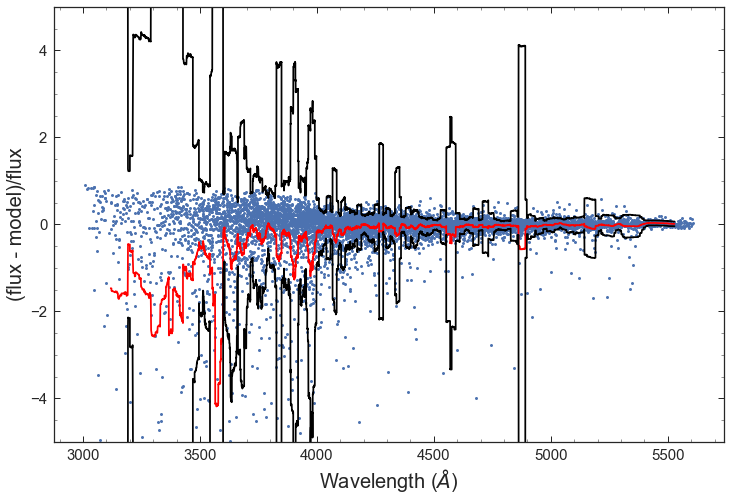

In [70]:
%matplotlib inline

plt.figure(figsize=[12,8])
plt.plot(waves[IDW],(flux[IDW] - mflux[IDW])/flux[IDW],'o',ms=3)
plt.plot(waves[IDW],rmean,'r',ms=2)
plt.plot(waves[IDW],np.array(rstd) + np.array(rmean),'k')
plt.plot(waves[IDW],np.array(rmean) - np.array(rstd),'k')
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('(flux - model)/flux',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-5,5)

In [10]:
eres = rzoo.zoo(df['resers'],df['wv'])

In [11]:
rmean = rzoo.rollapply(eres,50,'mean', fill = 'NA', align ='left')
rstd = rzoo.rollapply(eres,50,'sd', fill = 'NA', align ='left')

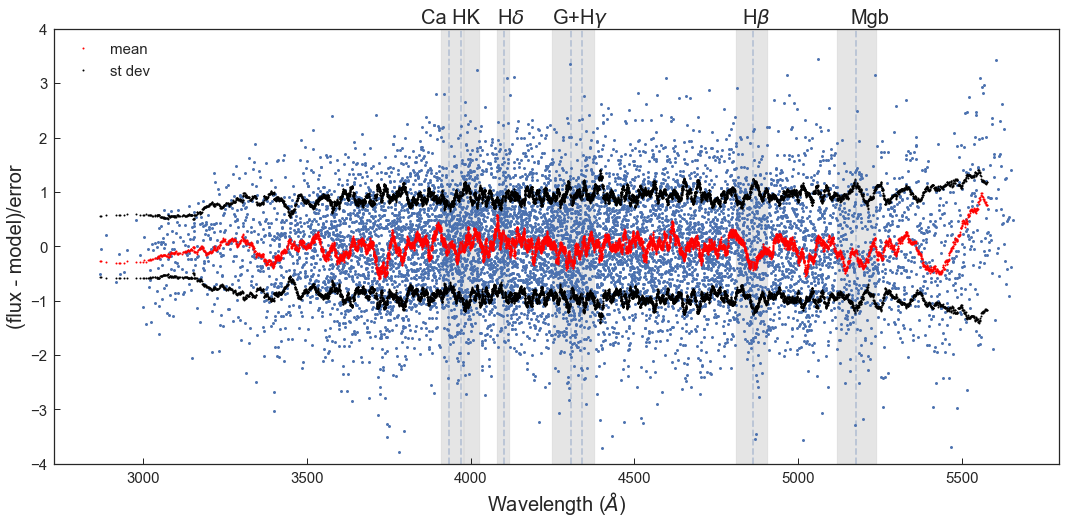

-0.0884509343774
0.0116999159168
0.89578607012
0.961041450289


In [21]:
plt.figure(figsize=[18,8])
plt.plot(waves[IDW],(mflux[IDW] - flux[IDW])/error[IDW],'o',ms=3)
plt.plot(waves[IDW],rmean,'ro',ms=2, label = 'mean')
plt.plot(waves[IDW],rstd,'ko',ms=2, label = 'st dev')
plt.plot(waves[IDW],-np.array(rstd),'ko',ms=2)
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('(flux - model)/error',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-4,4)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3850,4.1,'Ca HK',fontsize=20)
plt.text(4080,4.1,'H$\delta$',fontsize=20)
plt.text(4250,4.1,'G+H$\gamma$',fontsize=20)
plt.text(4830,4.1,'H$\\beta$',fontsize=20)
plt.text(5160,4.1,'Mgb',fontsize=20)
plt.legend(fontsize = 15)
plt.show()
# plt.savefig('../plots/flx_err_m_std2.png')
plt.close()

IDU = [U for U in range(len(waves)) if 3200 <= waves[U] <= 3800]
IDH = [U for U in range(len(waves)) if 3800 < waves[U]]

plt.figure(figsize=[12,8])
sea.distplot((mflux[IDU] - flux[IDU])/error[IDU])
plt.axvline(np.mean((mflux[IDU]- flux[IDU])/error[IDU]),color='k',linestyle='--',label = 'mean = -0.088' )
plt.axvline(np.std((mflux[IDU] - flux[IDU])/error[IDU]),color='k',linestyle='-.',label = 'st dev = 0.9' )
plt.axvline(-np.std((mflux[IDU] - flux[IDU])/error[IDU]),color='k',linestyle='-.')
plt.ylabel('P',fontsize = 20)
plt.xlabel('(flux - model)/error (3200 < $\lambda$ < 3800 $\AA$)',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 15)
plt.xlim(-5,5)
# plt.show()
plt.savefig('../plots/flx_err_hist_32-38.png')
plt.close()

IDU = [U for U in range(len(waves)) if 3200 <= waves[U] <= 3800]
IDH = [U for U in range(len(waves)) if 3800 < waves[U]]

plt.figure(figsize=[12,8])
sea.distplot((mflux[IDH] - flux[IDH])/error[IDH])
plt.axvline(np.mean((mflux[IDH]- flux[IDH])/error[IDH]),color='k',linestyle='--',label = 'mean = 0.012' )
plt.axvline(np.std((mflux[IDH] - flux[IDH])/error[IDH]),color='k',linestyle='-.',label = 'st dev = 0.96' )
plt.axvline(-np.std((mflux[IDH] - flux[IDH])/error[IDH]),color='k',linestyle='-.')
plt.ylabel('P',fontsize = 20)
plt.xlabel('(flux - model)/error ($\lambda$ > 3800 $\AA$)',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 15)
plt.xlim(-5,5)
# plt.show()
plt.savefig('../plots/flx_err_hist_gt38.png')
plt.close()

print np.mean((mflux[IDU] - flux[IDU])/error[IDU])
print np.mean((mflux[IDH] - flux[IDH])/error[IDH])
print np.std((mflux[IDU] - flux[IDU])/error[IDU])
print np.std((mflux[IDH] - flux[IDH])/error[IDH])